In [1]:
    import jsonschema, aiohttp, asyncio, types, fnmatch, dataclasses, builtins, jsonschema, collections, networkx, pathlib, IPython, ruamel.yaml, \
    inspect, ujson as json, io, pandas, jsonschema, time, mimetypes, nbformat, aiofiles, aiohttp, collections, functools, typing, sys
    from toolz.curried import *
    mime = compose(first, mimetypes.guess_type, str)            
    Path = type(pathlib.Path(''))
    IPython.display.HTML("""<style>#notebook-container, .container {width: 100%;}</style>""")

In [2]:
    sessions = {}

In [3]:
    class Composition(networkx.DiGraph):
        async def next(self, target, object, source=None):
            paths, source = [], source or type(object)
            try:
                next = pipe(concatv(
                    networkx.all_shortest_paths(self, source, target), networkx.all_simple_paths(self, source, target)
                ), map(drop(1)), map(list), 
                           filter(bool), groupby(len), valmap(map(first)), valmap(list), valmap(unique), valmap(list))
            except (networkx.NodeNotFound, networkx.NetworkXNoPath): next = {}
                
            if not len(next): return source, None
            for i in range(1, max(next.keys()) + 1):
                node = next.get(i, [])
                for node in next.get(i, []):
                    if isinstance(node, Validate):
                        if node.validate(object) and networkx.has_path(self, node, target): return source, node
                for node in next.get(i, []):
                    if isinstance(node, Forward) and node: return source, node()
                    if not isinstance(node, Validate): return source, node
            return source, node
        
        async def advance(self, *targets, object, composition):
            global __visits__
            for target in targets:
                callable, target = target, target.func if isinstance(target, functools.partial) else target

                if target not in self: object = target(object); continue
                    
                source, next = await self.next(target, object)
                composition.add_edge(source, next)
                if next is None: continue
                if next is builtins.object: continue
                if isinstance(next, types.ModuleType): continue
                    
                if next == target: next = callable    
                object = next() if object is None else next(object)        
                if inspect.isawaitable(object): object = await object
                    
                if next == target: continue
                elif isinstance(target, type):
                    if isinstance(type(object), target): continue
                else:
                    try:
                        if object == target: continue
                    except ValueError: ...
                object = await self.advance(target, object=object, composition=composition)      
                __visits__.add_edge(composition, target, object=object)
            return object
        
        async def text(self, path, attr='text', **kwargs):
            if isinstance(path, pathlib.Path):
                async with aiofiles.open(path, mode='r') as file: return await file.read()
            global sessions
            async with session[aiohttp].get(str(path), **kwargs) as response: return await response.text()
            
        async def json(self, path, attr='text', **kwargs):
            if isinstance(path, pathlib.Path):
                async with aiofiles.open(path, mode='r') as file: return json.loads(await file.read())
            global sessions
            async with sessions[aiohttp].get(str(path), **kwargs) as response: 
                try: return await response.json(content_type=None)
                except BaseException as Exception: return Exception
        
        async def sql(self, path, attr='text', **kwargs):
            async with aiosqlite.connect(path) as conn: 
                sessions[aiosqlite] = conn
        
        async def __call__(self, target, *object, keys=True, **data, ):
            global sessions, __visits__
            key, value, compositions, originals = [], [], [], []
            if not object: object = None,
            if not isiterable(target): target = target,
            async with aiohttp.ClientSession() as session:
                sessions[aiohttp] = session
                for object in object:
                    originals.append(object)
                    if isinstance(object, str):
                        original = str
                        for pattern in pipe(ado.nodes, filter(flip(isinstance)(Pattern)), list):
                            if pattern.validate(object): object = collections.UserString(object); break
                        else:
                            try: 
                                path = pathlib.Path(object)
                                if path.exists(): object = path
                                else: object = collections.UserString(object)
                            except:
                                forward = Forward[object]
                                if forward: object = forward
                    if isinstance(object, Forward): originals[-1], object = object, object()
                    compositions.append(Composition())
                    value.append(self.advance(*target, object=object, composition=compositions[-1]))
                    __visits__.add_edge(object, compositions[-1])
                value = await asyncio.gather(*value)
            try: 
                if keys: return dict(zip(originals, value))
            except TypeError: ...
            return value
        
        
        def __add__(self, object, *types): 
            self.add_path([Forward[object] if isinstance(object, str) else object for object in object])
            return self
        
        __iadd__ = __add__

In [4]:
    __visits__ = Composition()

In [5]:
    def yaml(object):
        try: import yaml
        except: from ruamel import yaml
        return yaml.safe_load(__import__('io').StringIO(str(object)))
            

In [6]:
    def new(cls, *args, _root=False): return type.__new__(cls, *args)
    typing.TypingMeta.__new__ = new
    def __getitem__(cls, object): return cls(object)
    typing.TypingMeta.__getitem__ = __getitem__


    class ForwardRef(getattr(typing, 'ForwardRef', getattr(typing, '_ForwardRef'))):
        def __bool__(self): self(); return self.__forward_evaluated__
        def __call__(self, globals=sys.modules, locals=sys.modules):
            if self.__forward_evaluated__: return self.__forward_value__
            try:
                self.__forward_value__, self.__forward_evaluated__ = eval(self.__forward_arg__, globals, locals), True
                return self.__forward_value__
            except: None
        
        def __hash__(self): self(); return hash(self.__forward_value__ if self.__forward_evaluated__ else self.__forward_arg__)
                
        def __eq__(self, object):
            self();
            try:
                if hash(self) == hash(object): return True
            except: 
                if self.__forward_arg__ == object: return True
            return False
        
    Forward = ForwardRef

In [7]:
    @dataclasses.dataclass
    class Validate:
        data: object = ''
        callable: callable = None
        def __hash__(self): return hash(str(self.data))
        def __len__(self): return len(self.data)
        async def __call__(self, object): 
            if self.callable:
                if isinstance(self.callable, Forward): 
                    self.callable()
                    if self: self.callable = self.callable()
                object = self.callable(object) 
                if inspect.isawaitable(object): object = await object
            return object
        
    class Mime(Validate, collections.UserString):
        def validate(self, object): 
            if isinstance(object, type(self)): return hash(object) == hash(self)
            return not self.data or self.data == mime(str(object))
        

In [8]:
    class Pattern(collections.UserList, Validate): 
        def __init__(self, *args, **kwargs):
            self.callable = kwargs.pop('callable', None)
            super().__init__(*args, **kwargs)
        def validate(self, object): return any(fnmatch.fnmatch(str(object), pattern) for pattern in self.data)
        def __hash__(self): return hash(tuple(self.data))
        

In [9]:
    class Schema(jsonschema.Draft4Validator, Validate):
        def __init__(self, *args, **kwargs):
            self.callable = kwargs.pop('callable', None)
            super().__init__(*args, **kwargs)
            
        @property
        def data(self): return self.schema
        def validate(self, object):
            if isinstance(object, type(self)): return hash(object) == hash(self)
            try: return super().validate(object) or True
            except jsonschema.ValidationError: return False
        
        @classmethod
        def new(cls, type, **kwargs):
            class Model(__import__('pydantic').BaseModel): object: type
            schema = json.loads(Model.schema_json())['properties']['object']
            return cls(schema.pop('title') and schema, **kwargs)

In [10]:
    def series_to_frame(series):
        if series.dtypes == pandas.np.dtype('O'): return series.apply(pandas.Series)
        return series.to_frame()

In [11]:
    mimetypes.add_type('text/markdown', '.md')
    mimetypes.add_type('text/markdown', '.markdown')
    mimetypes.add_type('application/x-sqlite3', '.sqlite')
    mimetypes.add_type('application/x-yaml', '.yml')
    mimetypes.add_type('application/x-yaml', '.yaml')

In [71]:
    ado = Composition()
    JSON = Mime('application/json', callable=ado.json)
    Web = Pattern(['http://*', 'https://*'], callable=ado.json)
    ado + [Path, ado.text, str]
    ado + [Path, JSON, dict, 'IPython.display.JSON'] + [JSON, list, 'IPython.display.JSON']+ [JSON, int]
    ado + [collections.UserString, Web, dict] + [Web, list] + [Web, float] + [Web, int]
    ado + [collections.UserString, Mime('application/json', callable=ado.text), str]
    ado + [dict, 'pandas.Series', series_to_frame, 'pandas.DataFrame'] 
    ado + [list, Schema.new(typing.List[typing.Union[int, None, float, str]], callable=Forward['pandas.Series']), 'pandas.Series']
    ado + [list, Schema.new(typing.List[typing.Union[list, dict]], callable=Forward['pandas.DataFrame']), 'pandas.DataFrame', 'pandas.DataFrame.transpose']
    ado + [dict, Schema.new(typing.Dict[str, list], callable=partial(networkx.from_dict_of_lists, create_using=networkx.DiGraph)), networkx.DiGraph]
    ado + [dict, Schema.new(typing.Dict[str, dict], callable=partial(networkx.from_dict_of_dicts, create_using=networkx.DiGraph)), networkx.DiGraph]
    ado + [dict, Schema.new(typing.Dict[str, list], callable=networkx.from_dict_of_lists), networkx.Graph]
    ado + [dict, Schema.new(typing.Dict[str, dict], callable=networkx.from_dict_of_dicts), networkx.Graph]
    ado + [collections.UserString, str, yaml, dict]
    ado + [collections.UserString, str, yaml, list]
    ado + [collections.UserString, str, yaml, float]
    ado + [collections.UserString, str, yaml, int]
    ado + [collections.UserString, yaml, str]
    ado + [Path, Mime('application/x-yaml', callable=compose(collections.UserString, ado.text)), str]
    ado + [networkx.DiGraph, networkx.to_edgelist, networkx.classes.reportviews.OutEdgeDataView, list]
    ado + [networkx.DiGraph, networkx.nx_pydot.to_pydot, 'pydot.Dot', 'graphviz.Source', Forward['graphviz.Source._repr_svg_'], str]
    ado + [networkx.Graph, networkx.nx_pydot.to_pydot, 'pydot.Dot', 'graphviz.Source', Forward['graphviz.Source._repr_svg_'], str]


In [72]:
    first(await ado(pandas.DataFrame, 'data.json', keys=False))

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
index,ZRRVgPxAbg,qGdbMygKUl,MFEpsjeg81,Bc5QYEyyvO,HmTeNtf2KE,64XpwGGKX4,FDGUaeSGrl,9bnZ4FYWx2,AwjEKKungG,NXaBII16Fj,...,xwTl85EoQF,vXzvHqbkN9,HIVHjSMo0C,2P90ZEkuB4,t78MDAdN8q,twVQDkT4Ml,J3Xm342gpK,A0PPGcOKtR,NnuL0L7diK,Q8ZNWO1pjT
A,-1.13811,0.932169,-0.278003,-0.315296,-0.41495,-1.29303,0.0666345,-1.32863,0.86664,0.414605,...,0.375973,-0.666088,-1.82705,-0.624332,-0.0506713,-2.76588,0.682396,-1.15344,0.899535,1.21765
B,-0.554226,0.0662085,0.804182,-0.558954,-0.107526,-0.275852,-1.17587,0.703497,-1.45832,0.481333,...,-0.327619,1.51967,-1.29964,0.876575,-0.110464,1.14753,0.725946,-0.980484,0.761013,0.424012
C,-0.303604,-1.12484,0.845789,0.703738,-0.243205,-2.29765,0.392907,-1.57246,0.891363,-2.16405,...,-0.761711,0.84413,-0.0749852,-0.3664,-0.135025,-1.64376,-1.62894,-0.145673,0.274579,0.282331
D,-0.304571,1.18461,-0.477547,-0.816047,0.85921,-0.366217,-0.426007,0.137321,-1.17364,-0.597233,...,-0.00921832,-0.409743,0.755613,-1.8391,0.340917,2.17179,-0.0148665,-1.59233,0.278727,1.1311


In [73]:
    import pydot, graphviz

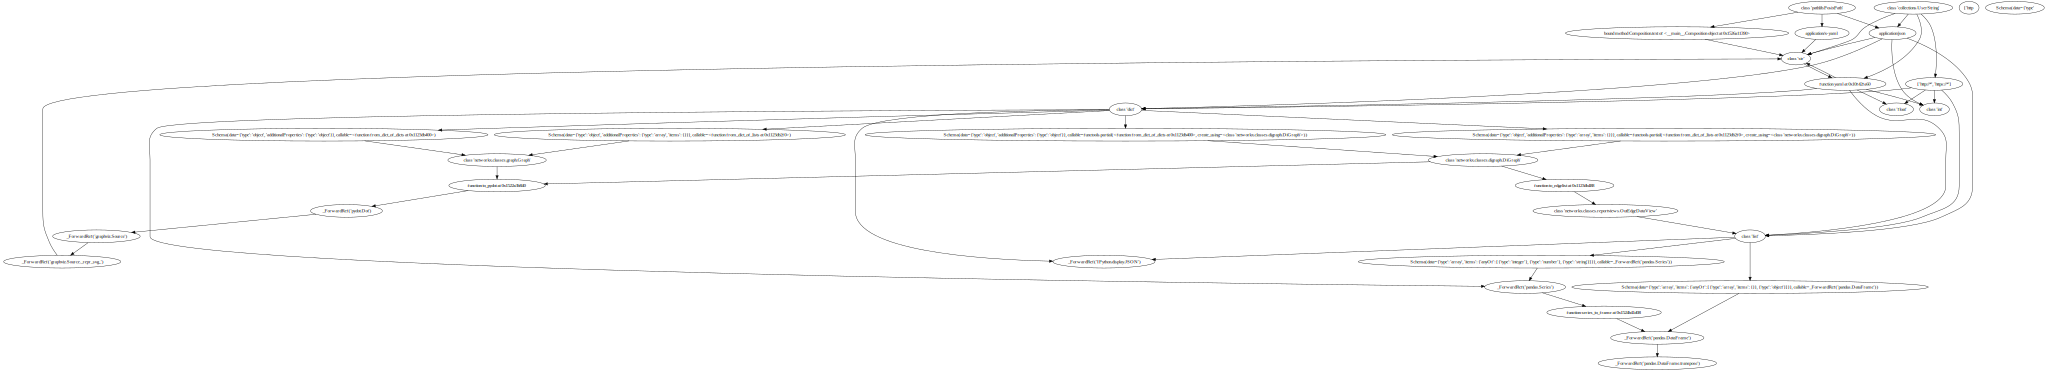

In [74]:
    first(await ado((networkx.to_directed, graphviz.Source), Forward['__main__.ado'], keys=False))

In [75]:
    %matplotlib inline

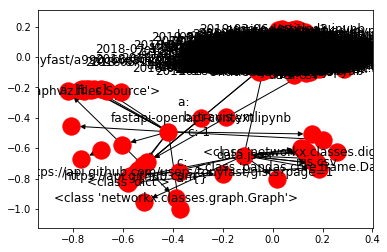

In [76]:
    networkx.draw_networkx(__visits__)

In [77]:
    first(await ado((pandas.DataFrame), 'data.json', keys=False))

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
index,ZRRVgPxAbg,qGdbMygKUl,MFEpsjeg81,Bc5QYEyyvO,HmTeNtf2KE,64XpwGGKX4,FDGUaeSGrl,9bnZ4FYWx2,AwjEKKungG,NXaBII16Fj,...,xwTl85EoQF,vXzvHqbkN9,HIVHjSMo0C,2P90ZEkuB4,t78MDAdN8q,twVQDkT4Ml,J3Xm342gpK,A0PPGcOKtR,NnuL0L7diK,Q8ZNWO1pjT
A,-1.13811,0.932169,-0.278003,-0.315296,-0.41495,-1.29303,0.0666345,-1.32863,0.86664,0.414605,...,0.375973,-0.666088,-1.82705,-0.624332,-0.0506713,-2.76588,0.682396,-1.15344,0.899535,1.21765
B,-0.554226,0.0662085,0.804182,-0.558954,-0.107526,-0.275852,-1.17587,0.703497,-1.45832,0.481333,...,-0.327619,1.51967,-1.29964,0.876575,-0.110464,1.14753,0.725946,-0.980484,0.761013,0.424012
C,-0.303604,-1.12484,0.845789,0.703738,-0.243205,-2.29765,0.392907,-1.57246,0.891363,-2.16405,...,-0.761711,0.84413,-0.0749852,-0.3664,-0.135025,-1.64376,-1.62894,-0.145673,0.274579,0.282331
D,-0.304571,1.18461,-0.477547,-0.816047,0.85921,-0.366217,-0.426007,0.137321,-1.17364,-0.597233,...,-0.00921832,-0.409743,0.755613,-1.8391,0.340917,2.17179,-0.0148665,-1.59233,0.278727,1.1311


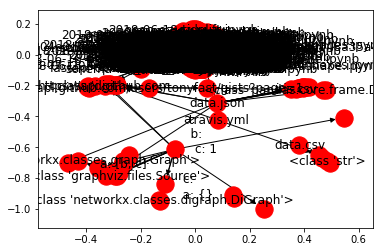

In [78]:
    networkx.draw_networkx(__visits__)

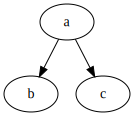

In [79]:
    first(await ado((graphviz.Source), """a: [b, c]""", keys=False))

In [80]:
    (await ado(str, 'data.csv', keys=False))

[',index,A,B,C,D\n0,ZRRVgPxAbg,-1.1381053526397178,-0.5542260677080425,-0.30360400428542816,-0.30457129683531264\n1,qGdbMygKUl,0.9321689226041314,0.0662085087188136,-1.1248441325746732,1.1846076177128924\n2,MFEpsjeg81,-0.278003471842151,0.8041818824494312,0.84578858975042,-0.47754716472179953\n3,Bc5QYEyyvO,-0.315296255352231,-0.5589544663360468,0.7037384743642491,-0.8160470869530047\n4,HmTeNtf2KE,-0.41495008315074017,-0.10752604833161665,-0.2432048994073809,0.859210141691628\n5,64XpwGGKX4,-1.2930293484996196,-0.2758519110479252,-2.2976499076043804,-0.3662166662698709\n6,FDGUaeSGrl,0.06663447861107852,-1.1758666707003866,0.3929067465028211,-0.4260068958456979\n7,9bnZ4FYWx2,-1.3286309582158133,0.7034972309309938,-1.5724617450346297,0.13732102848903235\n8,AwjEKKungG,0.8666398435263217,-1.4583153243041025,0.8913630866616473,-1.1736426017583441\n9,NXaBII16Fj,0.4146053431503641,0.48133348040331003,-2.1640546909701106,-0.5972330145300836\n10,qEIcjlnGHI,2.190635651762555,-0.32217725354666465,-

In [81]:
    t = time.time()
   
    gists = (
       await ado((dict, pandas.DataFrame), *(F"""https://api.github.com/users/tonyfast/gists?page={_}""" for _ in range(1, 2)), keys=False))
    print(time.time()-t)
    

0.6332528591156006


In [82]:
       await ado(dict, """https://api.github.com""", keys=False)
    

[{'current_user_url': 'https://api.github.com/user',
  'current_user_authorizations_html_url': 'https://github.com/settings/connections/applications{/client_id}',
  'authorizations_url': 'https://api.github.com/authorizations',
  'code_search_url': 'https://api.github.com/search/code?q={query}{&page,per_page,sort,order}',
  'commit_search_url': 'https://api.github.com/search/commits?q={query}{&page,per_page,sort,order}',
  'emails_url': 'https://api.github.com/user/emails',
  'emojis_url': 'https://api.github.com/emojis',
  'events_url': 'https://api.github.com/events',
  'feeds_url': 'https://api.github.com/feeds',
  'followers_url': 'https://api.github.com/user/followers',
  'following_url': 'https://api.github.com/user/following{/target}',
  'gists_url': 'https://api.github.com/gists{/gist_id}',
  'hub_url': 'https://api.github.com/hub',
  'issue_search_url': 'https://api.github.com/search/issues?q={query}{&page,per_page,sort,order}',
  'issues_url': 'https://api.github.com/issues',

In [83]:
    await ado(pandas.Series, *pandas.concat(gists).files.apply(pandas.Series).stack().apply(pandas.Series).raw_url[:1])

{'https://gist.githubusercontent.com/tonyfast/a990c66c804e0dbed659b66d222aea87/raw/9e0e90ce4d148a35a4b2e3109d04f233fd6484cc/awidgetable.ipynb': cells             [{'cell_type': 'markdown', 'metadata': {}, 'so...
 metadata          {'kernelspec': {'display_name': 'Python 3', 'l...
 nbformat                                                          4
 nbformat_minor                                                    4
 dtype: object}

In [84]:
    #pandas.concat(await ado(pandas.Series, *Path().glob('*.ipynb'))).unstack(-1)

In [85]:
    (await ado(pandas.Series, 'data.json', 'fastapi-openapi-context.ipynb'))

{'data.json': index    {'0': 'ZRRVgPxAbg', '1': 'qGdbMygKUl', '2': 'M...
 A        {'0': -1.1381053526, '1': 0.9321689226, '2': -...
 B        {'0': -0.5542260677, '1': 0.0662085087, '2': 0...
 C        {'0': -0.3036040043, '1': -1.1248441326, '2': ...
 D        {'0': -0.3045712968, '1': 1.1846076177, '2': -...
 dtype: object,
 'fastapi-openapi-context.ipynb': cells             [{'cell_type': 'markdown', 'metadata': {}, 'so...
 metadata          {'kernelspec': {'display_name': 'p6', 'languag...
 nbformat                                                          4
 nbformat_minor                                                    2
 dtype: object}

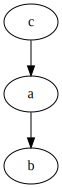

In [86]:
    first(await ado(graphviz.Source, """
    a:
        b: 
            c: 1
            
    c: 
        a: {}""", keys=False))

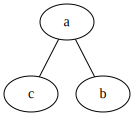

In [87]:
    first(await ado((networkx.Graph, graphviz.Source), """
    a:
        b: 
            c: 1
            
    c: 
        a: {}""", keys=False))

In [88]:
    pandas.concat(await ado(pandas.DataFrame, 'data.json', keys=False))

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
index,ZRRVgPxAbg,qGdbMygKUl,MFEpsjeg81,Bc5QYEyyvO,HmTeNtf2KE,64XpwGGKX4,FDGUaeSGrl,9bnZ4FYWx2,AwjEKKungG,NXaBII16Fj,...,xwTl85EoQF,vXzvHqbkN9,HIVHjSMo0C,2P90ZEkuB4,t78MDAdN8q,twVQDkT4Ml,J3Xm342gpK,A0PPGcOKtR,NnuL0L7diK,Q8ZNWO1pjT
A,-1.13811,0.932169,-0.278003,-0.315296,-0.41495,-1.29303,0.0666345,-1.32863,0.86664,0.414605,...,0.375973,-0.666088,-1.82705,-0.624332,-0.0506713,-2.76588,0.682396,-1.15344,0.899535,1.21765
B,-0.554226,0.0662085,0.804182,-0.558954,-0.107526,-0.275852,-1.17587,0.703497,-1.45832,0.481333,...,-0.327619,1.51967,-1.29964,0.876575,-0.110464,1.14753,0.725946,-0.980484,0.761013,0.424012
C,-0.303604,-1.12484,0.845789,0.703738,-0.243205,-2.29765,0.392907,-1.57246,0.891363,-2.16405,...,-0.761711,0.84413,-0.0749852,-0.3664,-0.135025,-1.64376,-1.62894,-0.145673,0.274579,0.282331
D,-0.304571,1.18461,-0.477547,-0.816047,0.85921,-0.366217,-0.426007,0.137321,-1.17364,-0.597233,...,-0.00921832,-0.409743,0.755613,-1.8391,0.340917,2.17179,-0.0148665,-1.59233,0.278727,1.1311


In [89]:
    await ado(dict, 'data.json')

{'data.json': {'index': {'0': 'ZRRVgPxAbg',
   '1': 'qGdbMygKUl',
   '2': 'MFEpsjeg81',
   '3': 'Bc5QYEyyvO',
   '4': 'HmTeNtf2KE',
   '5': '64XpwGGKX4',
   '6': 'FDGUaeSGrl',
   '7': '9bnZ4FYWx2',
   '8': 'AwjEKKungG',
   '9': 'NXaBII16Fj',
   '10': 'qEIcjlnGHI',
   '11': '1fNnWbStZw',
   '12': 'bnvkbltHLG',
   '13': 'P7xLisuKVA',
   '14': 'gsDI04CK8A',
   '15': 'U8BBDbZX1G',
   '16': 'mbWrBDgX04',
   '17': 'ECjFSyUkpB',
   '18': 'OX5VFucfeX',
   '19': 'l7KVkLide0',
   '20': 'xwTl85EoQF',
   '21': 'vXzvHqbkN9',
   '22': 'HIVHjSMo0C',
   '23': '2P90ZEkuB4',
   '24': 't78MDAdN8q',
   '25': 'twVQDkT4Ml',
   '26': 'J3Xm342gpK',
   '27': 'A0PPGcOKtR',
   '28': 'NnuL0L7diK',
   '29': 'Q8ZNWO1pjT'},
  'A': {'0': -1.1381053526,
   '1': 0.9321689226,
   '2': -0.2780034718,
   '3': -0.3152962554,
   '4': -0.4149500832,
   '5': -1.2930293485,
   '6': 0.0666344786,
   '7': -1.3286309582,
   '8': 0.8666398435,
   '9': 0.4146053432,
   '10': 2.1906356518,
   '11': -0.5081963836,
   '12': -0.7752061

In [56]:
    first(await ado(dict, """
    a:
        b: 
            c: 1
            
    c: 
        a: {}""", keys=False))

{'a': {'b': {'c': 1}}, 'c': {'a': {}}}

In [57]:
    first(await ado(networkx.DiGraph, """
    a:
        b: 
            c: 1
            
    c: 
        a: {}""", keys=False))

In [58]:
    q = first(await ado(graphviz.Source, """
    a:
        b: 
            c: 1
            
    c: 
        a: {}""", keys=False))

    first(await ado((graphviz.Source, IPython.display.SVG), """
    a:
        b: 
            c: 1
            
    c: 
        a: {}""", keys=False))

    type(first(await ado(IPython.display.SVG, """
    a:
        b: 
            c: 1
            
    c: 
        a: {}""", keys=False)))

In [61]:
    (await ado((dict, pandas.Series), 'data.json', keys=False))

[index    {'0': 'ZRRVgPxAbg', '1': 'qGdbMygKUl', '2': 'M...
 A        {'0': -1.1381053526, '1': 0.9321689226, '2': -...
 B        {'0': -0.5542260677, '1': 0.0662085087, '2': 0...
 C        {'0': -0.3036040043, '1': -1.1248441326, '2': ...
 D        {'0': -0.3045712968, '1': 1.1846076177, '2': -...
 dtype: object]

In [62]:
    (await ado(pandas.DataFrame, 'data.json', keys=False))

[                0           1           2           3           4           5  \
 index  ZRRVgPxAbg  qGdbMygKUl  MFEpsjeg81  Bc5QYEyyvO  HmTeNtf2KE  64XpwGGKX4   
 A        -1.13811    0.932169   -0.278003   -0.315296    -0.41495    -1.29303   
 B       -0.554226   0.0662085    0.804182   -0.558954   -0.107526   -0.275852   
 C       -0.303604    -1.12484    0.845789    0.703738   -0.243205    -2.29765   
 D       -0.304571     1.18461   -0.477547   -0.816047     0.85921   -0.366217   
 
                 6           7           8           9  ...          20  \
 index  FDGUaeSGrl  9bnZ4FYWx2  AwjEKKungG  NXaBII16Fj  ...  xwTl85EoQF   
 A       0.0666345    -1.32863     0.86664    0.414605  ...    0.375973   
 B        -1.17587    0.703497    -1.45832    0.481333  ...   -0.327619   
 C        0.392907    -1.57246    0.891363    -2.16405  ...   -0.761711   
 D       -0.426007    0.137321    -1.17364   -0.597233  ... -0.00921832   
 
                21          22          23          24

In [63]:
    #pandas.concat(await ado(pandas.DataFrame, 'https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv', 'iris.csv'), axis=1).T

In [64]:
    await ado(pandas.DataFrame, 'iris.csv')

/Users/tonyfast/anaconda/envs/p6/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: coroutine 'Composition.text' was never awaited
  ret = f(ret)


{'iris.csv': '<coroutine object Composition.text at 0x15269e07d8>'}

In [70]:
    await ado(str, Path('.travis.yml'))

{PosixPath('.travis.yml'): "language: python\npython:\n- '3.6'\n- 3.6-dev\ninstall:\n- python setup.py sdist bdist_wheel\n- pip install -r requirements.txt\n- python -m pip install dist/nostalgiaforever-*.tar.gz --ignore-installed --no-deps\nscript:\n- ipython --config nostalgiaforever/ipyconfig.py -m pytest nostalgiaforever/formal.ipynb\n- ipython --config nostalgiaforever/ipyconfig.py -m unittest tests\n- ipython profile create\n- importnb-install\n- ipython -m readme\ndeploy:\n  provider: pypi\n  user: docfast\n  password:\n    secure: GP4oO4GTNoTeGz++XDHSdMi4dexgVcqr5X5xmTs2m+Ol7YAFWcWhJqK7oXSh1JUZVAq7wm9mZf2uj9HUrJGiVrmplvQ94Z0LNDpvSrhNsPWGLfMltp5teYQ1EaVYNvVyaAQmQutbDUlms9BP6m1pr4eVDTIKzX+lz0UC4f4poZdJq1EfRCPMxOIyy4PXObMxlOllwH9gvLV7fRXrbgvMJg0skD2HTvmlLRjfSPsk6roiAwbodUOCYx7+KnnLpqh3OEeN3sCQzwi6rYIn31YWZg4DYXslR9ehaEXOzFuOLpOqX/0OxWasY2YDxlwCcUY0i3/7SFUAjrhxUTjteErEFmXiD0SrMY1SaFCWzT3AqY5jRO51OkqrmaWQW0oc3AV+joVraUo6Ud59bVoPLUVQQmpjsMHVT8QArVqfYxSmf+hweli8Wqxpo2rzpp+KWKCubQcboyZ

In [68]:
    await ado(dict, 'fastapi-openapi-context.ipynb')

{'fastapi-openapi-context.ipynb': '<coroutine object Composition.text at 0x15269e0990>'}

In [69]:
    t = time.time()
    notebooks = pandas.concat(await ado(pandas.Series, *pathlib.Path().glob('*.ipynb'))).unstack(-1)
    print(time.time()-t)
    notebooks.sample(3).T.dropna(how='all').sample(3).rename_axis(index='cell number')

TypeError: cannot concatenate object of type "<class 'str'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

In [ ]:
    notebooks.info()

In [ ]:
    files = gists.files.apply(pandas.Series).stack().apply(pandas.Series)

In [ ]:
    files.language.value_counts()

In [ ]:
    gists.info()

In [ ]:
    remote = gists.files.apply(pandas.Series).stack().apply(pandas.Series).set_index('language').loc['Jupyter Notebook']

    remote = await ado(pandas.DataFrame, *remote.raw_url[:50].values)

In [ ]:
    pipe(remote, valfilter(flip(isinstance)(pandas.DataFrame)), partial(pandas.concat, sort=False, axis=1)).T.sample(4)

In [ ]:
    pipe(ado, networkx.nx_pydot.to_pydot, operator.methodcaller('to_string'), __import__('graphviz').Source)
